## <u> Table of contents </u>

1. [Datasets](#load-datasets)
2. [Data exploration](#data-exploration)

    - [Univariate EDA](#univariate-eda)
    
    - [Multivariate EDA](#multivariate-eda)

3. [Feature engineering](#feature-engineering)
4. [Dealing with missing values](#missing-values)
5. [Fit base models](#base-models)

    - Logistic Regression, Decision Tree, Random Forest, LightGBM Classifier

6. [Finetune models](#finetune)

    - Logistic Regression, LightGBM Classifier

7. [Predict test set](#predict)

    - Logistic Regression
    
8. [Conclusion](#conclusion)

In [1]:
import pandas as pd 
import numpy as np 
import os
import re 
import requests
from typing import List, Tuple

# plot
import matplotlib.pyplot as plt 
import seaborn as sns 

# stats
from scipy.stats import chi2_contingency
from scipy import stats

# models
# import lazypredict
# from lazypredict.Supervised import LazyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

import lightgbm as lgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


---

<a id='load-datasets'></a>
## <u> Load datasets </u>

In [2]:
# import csv
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')

In [3]:
# sample rows
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
248,249,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,D35,S
762,763,1,3,"Barah, Mr. Hanna Assi",male,20.0,0,0,2663,7.2292,NaN,C
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
200,201,0,3,"Vande Walle, Mr. Nestor Cyriel",male,28.0,0,0,345770,9.5000,NaN,S
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S


In [4]:
test_df.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
403,1295,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,NaN,S
233,1125,3,"Linehan, Mr. Michael",male,NaN,0,0,330971,7.8792,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
195,1087,3,"Karlsson, Mr. Julius Konrad Eugen",male,33.0,0,0,347465,7.8542,NaN,S
267,1159,3,"Warren, Mr. Charles William",male,NaN,0,0,C.A. 49867,7.5500,NaN,S


---

<a id='data-exploration'></a>
## <u> Explore data </u>

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Seems like there are many null `Cabin` values
- While there are some null values from `Age` and `Embarked`

In [6]:
# check datatypes
for col in train_df.columns:
    print(f"Col: `{col}`; Dtype: {train_df[col].dtype}; Samples: {', '.join([str(i) for i in train_df[col].sample(3).tolist()])} \n")

Col: `PassengerId`; Dtype: int64; Samples: 488, 257, 264 

Col: `Survived`; Dtype: int64; Samples: 0, 0, 1 

Col: `Pclass`; Dtype: int64; Samples: 3, 3, 2 

Col: `Name`; Dtype: object; Samples: Lefebre, Miss. Mathilde, Leeni, Mr. Fahim ("Philip Zenni"), Nicholson, Mr. Arthur Ernest 

Col: `Sex`; Dtype: object; Samples: male, male, female 

Col: `Age`; Dtype: float64; Samples: 43.0, 24.0, 26.0 

Col: `SibSp`; Dtype: int64; Samples: 0, 1, 0 

Col: `Parch`; Dtype: int64; Samples: 0, 0, 1 

Col: `Ticket`; Dtype: object; Samples: C.A. 2315, PC 17593, 17464 

Col: `Fare`; Dtype: float64; Samples: 22.025, 0.0, 8.3 

Col: `Cabin`; Dtype: object; Samples: G6, nan, nan 

Col: `Embarked`; Dtype: object; Samples: S, S, S 



- Datatypes of each column seem to be correct

---

<a id='univariate-eda'></a>
## <u> Univariate EDA </u>

- Let's look at the distribution and count of values across the numeric and categorical features, respectively.
- To be univariate in nature first.

In [7]:
# define plot function
def univariate_eda(
    df: pd.DataFrame,
    col: str
):
    """
    Plot distribution or counts of numeric and categorical features, specified in `col` parameter.
    
    """
    
    plt.figure(figsize=(6,3))
    
    # distribution for numeric feature
    if np.issubdtype(df[col].dtype, np.number):
        sns.histplot(df[col], bins=10, kde=False, color='lightgreen')
        plt.title(f"Distribution of {col}", fontsize=10)
        plt.xlabel(col, fontsize=10)
        plt.xticks(fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
        plt.yticks(fontsize=10)
    # counts for categorical feature
    else:
        if df[col].nunique() <= 20: # only plot for categorical features with less than 20 unique values
            sns.countplot(x=df[col], palette='viridis')
            plt.title(f"Counts of {col}", fontsize=10)
            plt.xlabel(col, fontsize=10)
            plt.xticks(fontsize=10)
            plt.ylabel('Count', fontsize=10)
            plt.yticks(fontsize=10)
        else:
            print(f"{col} is a categorical feature with more than 20 unique values. Skip plot")  
        

Name is a categorical feature with more than 20 unique values. Skip plot
Ticket is a categorical feature with more than 20 unique values. Skip plot
Cabin is a categorical feature with more than 20 unique values. Skip plot


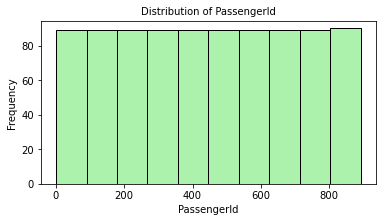

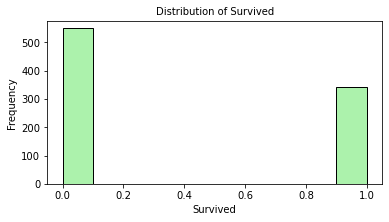

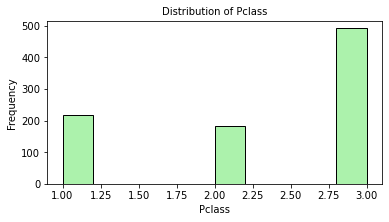

<Figure size 432x216 with 0 Axes>

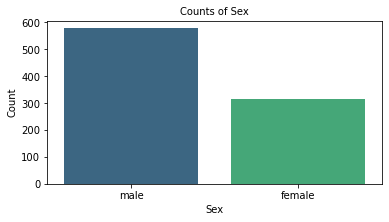

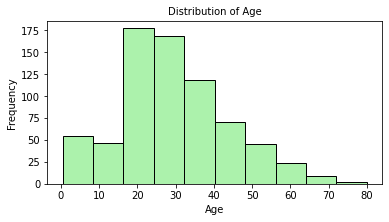

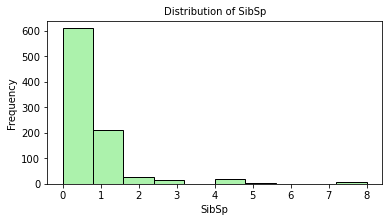

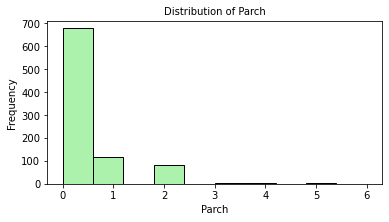

<Figure size 432x216 with 0 Axes>

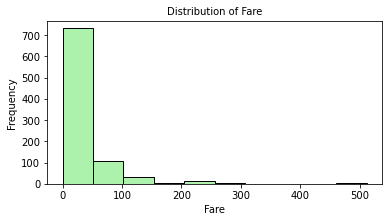

<Figure size 432x216 with 0 Axes>

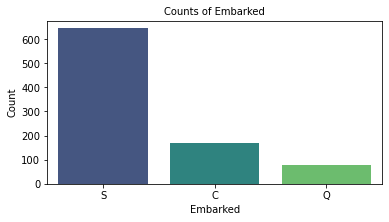

In [8]:
# plot 
for col in train_df.columns:
    univariate_eda(df=train_df, col=col)

- `Name`, `Ticket` and `Cabin` are categorical features with more than 10 unique values, which means we can be creative in engineering new features from these variables, rather than use their individual values for prediction.
- Similar with `PassengerId`, perhaps there is a way to manually bin IDs into categories for prediction. Perhaps there is a pattern to how the passenger IDs were originally assigned.

Other univariate insights:
- More people did not survive compared to those who did.
- More men than females.
- More people who boarded 3rd class compared to 1st and 2nd class. 
- More people within their 20s, 30s and 40s than the younger and older.
- A lot more people with 0 or 1 sibling/spouse on board.
- A lot more people with 0 or 1 child/parent on board.
- Most people paid fares within $0-50.
- Most people embarked from Southampton.

To note:
- The target variable does not seem to be too highly imbalanced.
- Some numeric variables seem to be highly skewed. Something to have in the back of my mind if I am performing statistical inferences or fitting models that assume normal distribution.

---

<a id='feature-engineering'></a>
## <u> Feature engineering: Identify patterns from `Name`, `Ticket`, `Cabin` and `PassengerId`</u>

- Are there any interesting patterns in each of the above columns?
- Are these patterns correlated with the target variable (survived or not)?

<u> 1) `Name` </u>

In [9]:
# passenger names 
train_df['Name'].sample(20)

512                           McGough, Mr. James Robert
259                         Parrish, Mrs. (Lutie Davis)
92                          Chaffee, Mr. Herbert Fuller
772                                   Mack, Mrs. (Mary)
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
294                                    Mineff, Mr. Ivan
882                        Dahlberg, Miss. Gerda Ulrika
632                           Stahelin-Maeglin, Dr. Max
191                               Carbines, Mr. William
392                        Gustafsson, Mr. Johan Birger
217                        Jacobsohn, Mr. Sidney Samuel
789                            Guggenheim, Mr. Benjamin
663                                    Coleff, Mr. Peju
761                      Nirva, Mr. Iisakki Antino Aijo
366    Warren, Mrs. Frank Manley (Anna Sophia Atkinson)
841                            Mudd, Mr. Thomas Charles
449                      Peuchen, Major. Arthur Godfrey
79                             Dowdell, Miss. El

- There is a format to the names. It starts off with a FIRST NAME, followed by a COMMA, then a PREFIX, then FAMILY NAME [First Name, Prefix, Family Name]

Others:
- Unique prefixes. What do they imply? Social class?
- Length of names - character-wise and token-wise

In [10]:
# define functions 
def extract_prefix(
    name: str,
    pattern: str = '\, ([A-Za-z]+)\.'
):
    """
    Given a string input, extract prefix, based on regex pattern specified in `pattern` parameter.
    
    """
    
    # pattern
    pattern = re.compile(rf"{pattern}")
    
    # regex search and extraction 
    match = pattern.search(name)
    
    if match:
        extract = match.group(1)
        return extract
    else:
        return 'null'
    
def extract_firstname(
    name: str,
    pattern: str = '([A-Za-z\s]+)\,'

):
    """
    Given a string input, extract first name, then count the number of unique first names and total characters. 
    
    """
    
    # pattern
    pattern = re.compile(rf"{pattern}")
    
    # regex search and extraction
    match = pattern.search(name)
    
    if match:
        extract = match.group(1)
        # number of names 
        names = extract.split(' ')
        len_names = len(names)
        # number of characters 
        chars = extract.replace(' ','')
        len_chars = len(extract)
        return len_names, len_chars
    else:
        return 0,0

def extract_familyname(
    name: str,
    pattern: str = '\. ([A-Za-z\s]+)'
):
    """
    Given a string input, extract family name, then count the number of unique family names and total characters.
    
    """
    
    # pattern
    pattern = re.compile(rf"{pattern}")
    
    # regex search and extraction
    match = pattern.search(name)
    
    if match:
        extract = match.group(1)
        # number of names 
        names = extract.split(' ')
        len_names = len(names)
        # number of characters 
        chars = extract.replace(' ','')
        len_chars = len(extract)
        return len_names, len_chars
    else:
        return 0,0


In [11]:
# extract 
train_df['prefix_name'] = train_df['Name'].apply(lambda x: extract_prefix(name=x))
train_df[['len_unq_firstname','len_char_firstname']] = train_df['Name'].apply(lambda x: pd.Series(extract_firstname(name=x)))
train_df[['len_unq_familyname','len_char_familyname']] = train_df['Name'].apply(lambda x: pd.Series(extract_familyname(name=x)))

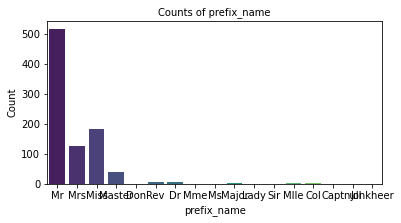

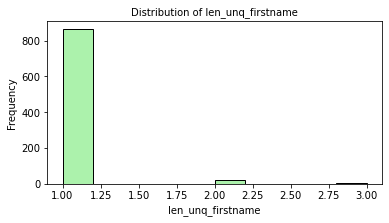

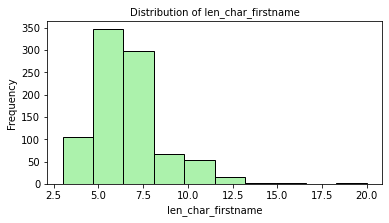

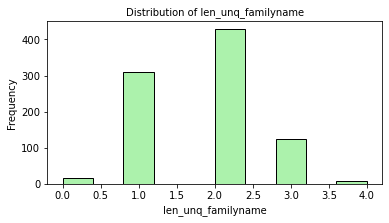

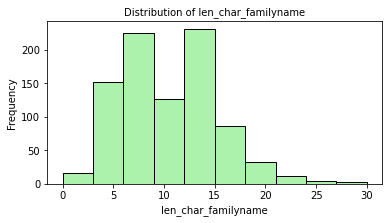

In [12]:
# visualise
for col in train_df.columns:
    if 'name' in col:
        univariate_eda(df=train_df, col=col)
    else:
        pass

- Most prefixes are 'Mr's, followed by 'Mrs' and 'Miss's, which is in line with the proportion of male:female passengers.
- There is a small majority of people with more than 1 recorded first names.
- Most people have first names with 5-8 characters. Some have names up to 20 character long (outliers).
- There are also outliers with the length of family names. 
- I wonder if there are any correlations between these and the target variable. 

In [13]:
# look at prefixes and gender
train_df.groupby(['Sex','prefix_name'])['prefix_name'].count()

Sex     prefix_name
female  Dr               1
        Lady             1
        Miss           182
        Mlle             2
        Mme              1
        Mrs            125
        Ms               1
        null             1
male    Capt             1
        Col              2
        Don              1
        Dr               6
        Jonkheer         1
        Major            2
        Master          40
        Mr             517
        Rev              6
        Sir              1
Name: prefix_name, dtype: int64

- There seems to be a fair bit of `Master`, `Rev` and `Dr`s among the men.

In [14]:
# show example of long character names
train_df[train_df['len_char_firstname']>=15]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix_name,len_unq_firstname,len_char_firstname,len_unq_familyname,len_char_familyname
307,308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)",female,17.0,1,0,PC 17758,108.9,C65,C,Mrs,3,20,4,17
505,506,0,1,"Penasco y Castellana, Mr. Victor de Satode",male,18.0,1,0,PC 17758,108.9,C65,C,Mr,3,20,3,16
873,874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0,NaN,S,Mr,2,15,1,6


In [15]:
# regroup categories with small counts into `others`
train_df['prefix_name'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Sir           1
Capt          1
Don           1
Lady          1
Jonkheer      1
Ms            1
null          1
Mme           1
Name: prefix_name, dtype: int64

In [16]:
# if count is less than 6
replace = []

for i,j in train_df['prefix_name'].value_counts().reset_index().iterrows():
    if j['prefix_name'] < 6:
        replace.append(j['prefix_name'])

for i in replace:
    train_df['prefix_name'] = train_df['prefix_name'].replace(i, 'others')

train_df['prefix_name'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Sir           1
Capt          1
Don           1
Lady          1
Jonkheer      1
Ms            1
null          1
Mme           1
Name: prefix_name, dtype: int64

- In the example above, seems like the `Penasco y Castellana`s were husband and wife, which is also indicated in `SibSp`.
- Additionally, I do wonder about the diversity of the passengers in terms of nationality.

<u> 2) `Ticket` </u>

In [17]:
# sample tickets
train_df['Ticket'].sample(20)

139         PC 17593
535     F.C.C. 13529
300             9234
181    SC/PARIS 2131
507           111427
383           113789
488       A.5. 18509
43     SC/Paris 2123
257           110152
679         PC 17755
659            35273
394          PP 9549
454         A/5 2817
748           113773
280           336439
154        Fa 265302
292    SC/Paris 2163
836           315097
706           223596
26              2631
Name: Ticket, dtype: object

- There are different formats to the tickets, too. 
- Some patterns I can observe are: 
    - xxxxxx (where x represents a number)
    - STON/x xxxxxxx
    - PC xxxxx
    - CA xxxxx
    - A/x xxxxx
    - SC/Paris xxxxx
- By and large, let's try to categorise tickets into a few groups based on the above patterns. 

In [18]:
# identify patterns 
patterns = {}

for i,j in train_df.iterrows():
    resp = re.match(r'^\D*', j['Ticket']).group()
    if len(resp) > 0:
        if resp not in patterns:
            patterns[resp] = 1
        else:
            patterns[resp] += 1
    else:
        pass

patterns

{'A/': 23,
 'PC ': 60,
 'STON/O': 6,
 'PP ': 3,
 'C.A. ': 27,
 'A./': 2,
 'SC/Paris ': 4,
 'S.C./A.': 1,
 'CA ': 6,
 'S.P. ': 1,
 'S.O.C. ': 5,
 'SO/C ': 1,
 'W./C. ': 9,
 'SOTON/OQ ': 7,
 'W.E.P. ': 1,
 'STON/O ': 12,
 'A': 1,
 'C ': 5,
 'SOTON/O.Q. ': 8,
 'SC/PARIS ': 5,
 'S.O.P. ': 1,
 'A.': 2,
 'Fa ': 1,
 'CA. ': 8,
 'LINE': 4,
 'F.C.C. ': 5,
 'W/C ': 1,
 'SW/PP ': 1,
 'SCO/W ': 1,
 'P/PP ': 2,
 'SC ': 1,
 'SC/AH ': 2,
 'A/S ': 1,
 'SC/AH Basle ': 1,
 'WE/P ': 2,
 'S.W./PP ': 1,
 'S.O./P.P. ': 3,
 'F.C. ': 1,
 'SOTON/O': 2,
 'S.C./PARIS ': 2,
 'C.A./SOTON ': 1}

In [19]:
# remove fullstops
train_df['Ticket'] = train_df['Ticket'].str.replace('.','')

# identify patterns 
patterns = {}

for i,j in train_df.iterrows():
    resp = re.match(r'^\D*', j['Ticket']).group()
    if len(resp) > 0:
        if resp not in patterns:
            patterns[resp] = 1
        else:
            patterns[resp] += 1
    else:
        pass

patterns

{'A/': 25,
 'PC ': 60,
 'STON/O': 6,
 'PP ': 3,
 'CA ': 41,
 'SC/Paris ': 4,
 'SC/A': 1,
 'SP ': 1,
 'SOC ': 5,
 'SO/C ': 1,
 'W/C ': 10,
 'SOTON/OQ ': 15,
 'WEP ': 1,
 'STON/O ': 12,
 'A': 3,
 'C ': 5,
 'SC/PARIS ': 7,
 'SOP ': 1,
 'Fa ': 1,
 'LINE': 4,
 'FCC ': 5,
 'SW/PP ': 2,
 'SCO/W ': 1,
 'P/PP ': 2,
 'SC ': 1,
 'SC/AH ': 2,
 'A/S ': 1,
 'SC/AH Basle ': 1,
 'WE/P ': 2,
 'SO/PP ': 3,
 'FC ': 1,
 'SOTON/O': 2,
 'CA/SOTON ': 1}

- A majority of train tickets are only in numbers.
- Only a small proportion of them fall in any one of the above formats.

In [20]:
# extract 
train_df['ticket_type'] = ''

for i,j in train_df.iterrows():
    resp = re.match(r'^\D*', j['Ticket']).group()
    if len(resp) > 0:
        train_df.loc[i,'ticket_type'] = resp
    else: # numbers only
        train_df.loc[i,'ticket_type'] = 'DIGITS ONLY'

train_df['ticket_type'].value_counts()

DIGITS ONLY     661
PC               60
CA               41
A/               25
SOTON/OQ         15
STON/O           12
W/C              10
SC/PARIS          7
STON/O            6
FCC               5
SOC               5
C                 5
LINE              4
SC/Paris          4
SO/PP             3
A                 3
PP                3
SOTON/O           2
WE/P              2
SW/PP             2
SC/AH             2
P/PP              2
FC                1
SCO/W             1
SOP               1
CA/SOTON          1
Fa                1
SO/C              1
SP                1
SC                1
SC/AH Basle       1
A/S               1
SC/A              1
WEP               1
Name: ticket_type, dtype: int64

In [21]:
# rearrange potential typos
sorted(train_df['ticket_type'].unique())

['A',
 'A/',
 'A/S ',
 'C ',
 'CA ',
 'CA/SOTON ',
 'DIGITS ONLY',
 'FC ',
 'FCC ',
 'Fa ',
 'LINE',
 'P/PP ',
 'PC ',
 'PP ',
 'SC ',
 'SC/A',
 'SC/AH ',
 'SC/AH Basle ',
 'SC/PARIS ',
 'SC/Paris ',
 'SCO/W ',
 'SO/C ',
 'SO/PP ',
 'SOC ',
 'SOP ',
 'SOTON/O',
 'SOTON/OQ ',
 'SP ',
 'STON/O',
 'STON/O ',
 'SW/PP ',
 'W/C ',
 'WE/P ',
 'WEP ']

- Without fully understanding what each ticket type means, I won't be able to draw any insights from a potential relationship between ticket type and the target variable. 
- In any case, the top 10 ticket types are: `DIGITS ONLY`, `PC`, `CA`, `A/`, `SOTON`, `STON`, `W/C`, `SC`, `STON`, `FCC`
- I will group the other ticket types with similar resemblances with any one of the above ticket types. The rest I will categorize as `OTHERS`
- Again, I am making a lot of assumptions here.

In [22]:
regroup_ticket_types = {'CA': ['CA/SOTON'],
                        'A': ['A/','A/S'],
                        'SOTON': ['SOTON/O','SOTON/OQ','STON/O','STON/O ','SOTONQ'],
                        'SC': ['SC/A','SC/AH ','SC/AH Basle','SC/PARIS ','SC/Paris '],
                        'FCC ': ['FC ']}

for k,v in regroup_ticket_types.items():
    # replace 
    for i in v:
        train_df['ticket_type'] = train_df['ticket_type'].str.replace(i, k)

train_df['ticket_type'].value_counts()

DIGITS ONLY    661
PC              60
CA              42
A               28
SOTON           27
SC              12
W/C             10
SOTON            8
FCC              6
SOC              5
C                5
LINE             4
SO/PP            3
PP               3
P/PP             2
WE/P             2
SCH              2
SW/PP            2
SOP              1
WEP              1
Fa               1
SCO/W            1
AS               1
SO/C             1
SP               1
SC               1
SCH Basle        1
Name: ticket_type, dtype: int64

In [23]:
# bin the rest as 'OTHERS'
as_others = train_df['ticket_type'].value_counts().to_frame().reset_index().tail(20)['ticket_type'].unique()

for i,j in train_df.iterrows():
    for a in as_others:
        if j['ticket_type'] == a:
            train_df.loc[i,'ticket_type'] = 'OTHERS'
        else:
            pass
    
train_df['ticket_type'].value_counts()

DIGITS ONLY    661
PC              60
CA              42
A               28
SOTON           27
SC              12
W/C             10
SOTON            8
FCC              6
SOC              5
C                5
LINE             4
SO/PP            3
PP               3
P/PP             2
WE/P             2
SCH              2
SW/PP            2
SOP              1
WEP              1
Fa               1
SCO/W            1
AS               1
SO/C             1
SP               1
SC               1
SCH Basle        1
Name: ticket_type, dtype: int64

<u> 3) `Cabin` </u>

In [24]:
# missing values
train_df['Cabin'].isnull().sum() / len(train_df)*100

77.10437710437711

In [25]:
# non missing Cabin values
train_df[~train_df['Cabin'].isnull()]['Cabin'].sample(20)

331           C124
340             F2
577            E44
309            E36
587            B41
689             B5
177            C49
558            E67
486            C93
303           E101
498        C22 C26
102            D26
456            E38
572            E25
550            C70
632            B50
27     C23 C25 C27
66             F33
195            B80
245            C78
Name: Cabin, dtype: object

- Again, without any context of what each cabin type means, and why some records have multiple cabin types, I will group them into 3 new columns:
- One for cabin type (starting with the first alphabet of the cabin)
- One for cabin frequency (number of indicated cabins, for eg a single record of C23 C25 and C27 would indicate 3 assigned cabins)
- And another for whether or not cabin was indicated (boolean yes or no). Maybe a majority of passengers did not reserve for themselves cabins. They only had access to it on a first come first serve basis.

In [26]:
# extract first alphabet of cabin
train_df['Cabin'] = train_df['Cabin'].fillna('-')

train_df['cabin_type'] = [i[0] for i in train_df['Cabin']]
train_df['cabin_type'].value_counts()

-    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_type, dtype: int64

In [27]:
# cabin frequency
train_df['cabin_frequency'] = [len(i.split( )) if i != '-' else 0 for i in train_df['Cabin']]

train_df['cabin_frequency'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_frequency, dtype: int64

In [28]:
# cabin assigned or not 
train_df['cabin_assigned'] = [1 if i != '-' else 0 for i in train_df['Cabin']]

train_df['cabin_assigned'].value_counts()

0    687
1    204
Name: cabin_assigned, dtype: int64

<u> 4) `PassengerId` </u>

- Similarly I am going to assume here that there is an unobserved pattern to how passengers are assigned their IDs.
- I will group the IDs into equal bins of 5.

In [29]:
train_df['passengerid_bins'] = pd.cut(train_df['PassengerId'], bins=5)

train_df['passengerid_bins'].value_counts()

(0.11, 179.0]     179
(179.0, 357.0]    178
(357.0, 535.0]    178
(535.0, 713.0]    178
(713.0, 891.0]    178
Name: passengerid_bins, dtype: int64

In [30]:
# define labels
labels = ['1. 0-179', '2. 179-357', '3. 357-535', '4. 535-713', '5. 713-891']

train_df['passengerid_bins'] = pd.cut(train_df['PassengerId'], bins=5, labels=labels)
train_df['passengerid_bins'] = train_df['passengerid_bins'].astype('object')

train_df['passengerid_bins'].value_counts()

1. 0-179      179
3. 357-535    178
2. 179-357    178
4. 535-713    178
5. 713-891    178
Name: passengerid_bins, dtype: int64

---

<a id='missing-values'></a>
## <u> Dealing with missing values </u>


In [31]:
train_df.isnull().sum()

PassengerId              0
Survived                 0
Pclass                   0
Name                     0
Sex                      0
Age                    177
SibSp                    0
Parch                    0
Ticket                   0
Fare                     0
Cabin                    0
Embarked                 2
prefix_name              0
len_unq_firstname        0
len_char_firstname       0
len_unq_familyname       0
len_char_familyname      0
ticket_type              0
cabin_type               0
cabin_frequency          0
cabin_assigned           0
passengerid_bins         0
dtype: int64

<u> 1) `Age` and `age_bins` </u>

- 177 missing values
- Impute with mean age

In [32]:
# calculate mean
mean_age = round(train_df['Age'].mean(),0)

# impute 
train_df['Age'] = train_df['Age'].fillna(mean_age)
train_df['age_bins'] = train_df['Age'].fillna(mean_age)

train_df['Age'].isnull().sum()

0

In [33]:
# bin ages too
train_df['age_bins'] = pd.cut(train_df['Age'], bins=5)

train_df['age_bins'].value_counts()

(16.336, 32.252]    523
(32.252, 48.168]    188
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: age_bins, dtype: int64

In [34]:
# define labels
labels = ['1. 0-16', '2. 16-32', '3. 32-48', '4. 48-64', '5. 64-80']

train_df['age_bins'] = pd.cut(train_df['Age'], bins=5, labels=labels)
train_df['age_bins'] = train_df['age_bins'].astype('object')

train_df['age_bins'].value_counts()

2. 16-32    523
3. 32-48    188
1. 0-16     100
4. 48-64     69
5. 64-80     11
Name: age_bins, dtype: int64

<u> 2) `Embarked` </u>
- 2 missing values
- Impute with `-` 

In [35]:
train_df['Embarked'] = train_df['Embarked'].fillna('-')

train_df['Embarked'].isnull().sum()

0

In [36]:
assert train_df.isnull().sum().sum() == 0

---

<a id='multivariate-eda'></a>
## <u> Multivariate EDA </u>

- Are there features that strongly correlate with the target variable?
- Since the target variable is a categorical one, we can use the following statistical tests to determine if there is a significant difference in distributions between the outcomes:
    - Chi-square test for 2 categorical variables
    - T-test for 1 categorical variable and 1 continuous variable

In [37]:
# define function
def stats_test(
    df: pd.DataFrame,
    target_variable: str,
    categorical_variable: list,
    numeric_variable: list
):
    """
    Run statistical test on each pair. Either Chi-square or T-test depending on datatype of independent variable.
    
    """
    
    df_copy = df.copy()
    
    # function to plot charts later
    def multivariate_eda(df: pd.DataFrame, x: str, y: str, x_categorical: bool):
        # grouped bar chart for categorical variables
        if x_categorical:
            plt.figure(figsize=(6,3))
            sns.countplot(x=df.sort_values(by=x)[x], hue=train_df[y],palette='viridis')
            plt.title(f"Counts of {x} and {y}", fontsize=10)
            plt.xlabel(x, fontsize=10)
            plt.xticks(fontsize=10, rotation=45)
            plt.ylabel('count', fontsize=10)
            plt.yticks(fontsize=10)
            plt.show()
        
        # histogram for numeric
        else: 
            plt.figure(figsize=(6,3))
            sns.histplot(data=df, x=x, hue=y)
            plt.title(f"Distributions of {y} against {x}", fontsize=10)
            plt.xlabel(x, fontsize=10)
            plt.xticks(fontsize=10)
            plt.ylabel('distribution', fontsize=10)
            plt.yticks(fontsize=10)
            plt.show()
    
    # calculate stats
    # chi2
    print('Calculating for categorical variables... \n')
    for i in categorical_variable:
        print(i)
        # fill missing values with something
        missing = df_copy[i].isnull().sum()
        df_copy[i] = df_copy[i].fillna('-')
        
        # contingency table
        contingency_table = pd.crosstab(df_copy[i], df_copy[target_variable])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"{missing} missing values filled with '-'")
        print(f"{i} - chi2: {round(chi2,4)}; p value: {round(p,10)} \n")
        
        # plot
        multivariate_eda(df=df_copy, x=i, y=target_variable, x_categorical=True)
    
    # t-test
    print('Calculating for numeric variables... \n')
    for j in numeric_variable:
        # fill missing values with something
        missing = df_copy[j].isnull().sum()
        df_copy[j] = df_copy[j].fillna(0)
        
        # remove outliers by using IQR
        q1 = np.percentile(df_copy[j], 25)
        q3 = np.percentile(df_copy[j], 75)
        iqr = q3-q1
        df_copy_rem_outliers = df_copy[(df_copy[j] >= (q1-iqr*1.5)) & (df_copy[j] <= (q3+iqr*1.5))]
        print(f"q1: {q1}, q3: {q3}")
        print((q1-iqr*1.5))
        
        # t test
        group1 = df_copy_rem_outliers[df_copy_rem_outliers[target_variable]==1][j]
        group2 = df_copy_rem_outliers[df_copy_rem_outliers[target_variable]==0][j]
        t, p = stats.ttest_ind(group1, group2)
        print(f"{missing} missing values filled with 0")
        print(f"{j} - t statistic: {round(t,4)}; p value: {round(p,10)} \n")
        
        # plot
        multivariate_eda(df=df_copy_rem_outliers, x=j, y=target_variable, x_categorical=False)

Calculating for categorical variables... 

Pclass
0 missing values filled with '-'
Pclass - chi2: 102.889; p value: 0.0 



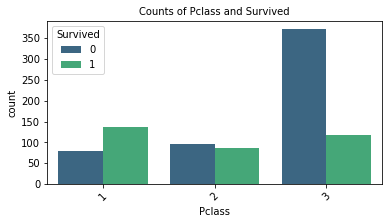

Sex
0 missing values filled with '-'
Sex - chi2: 260.717; p value: 0.0 



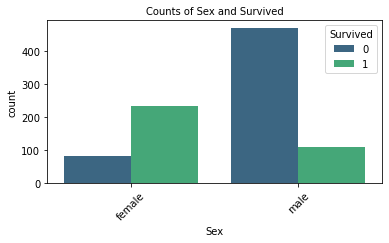

SibSp
0 missing values filled with '-'
SibSp - chi2: 37.2718; p value: 1.5586e-06 



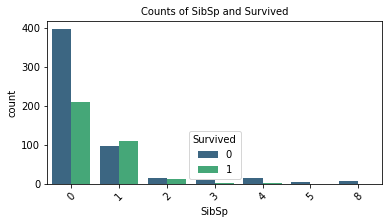

Parch
0 missing values filled with '-'
Parch - chi2: 27.9258; p value: 9.70353e-05 



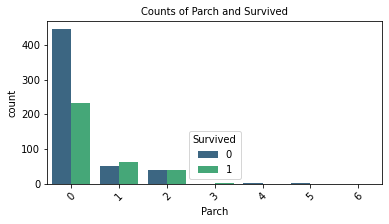

Embarked
0 missing values filled with '-'
Embarked - chi2: 29.6706; p value: 1.6187e-06 



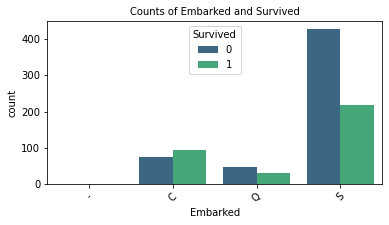

prefix_name
0 missing values filled with '-'
prefix_name - chi2: 300.023; p value: 0.0 



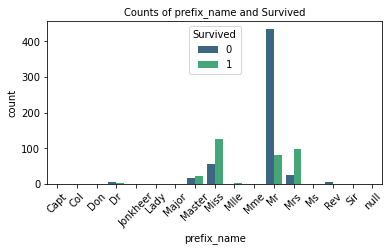

len_unq_firstname
0 missing values filled with '-'
len_unq_firstname - chi2: 3.4248; p value: 0.1804359084 



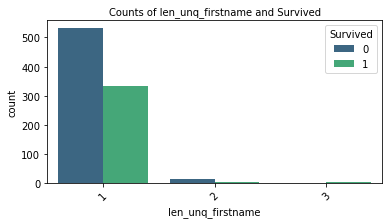

len_char_firstname
0 missing values filled with '-'
len_char_firstname - chi2: 10.3782; p value: 0.6627528861 



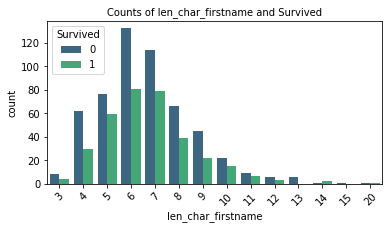

len_unq_familyname
0 missing values filled with '-'
len_unq_familyname - chi2: 56.7972; p value: 0.0 



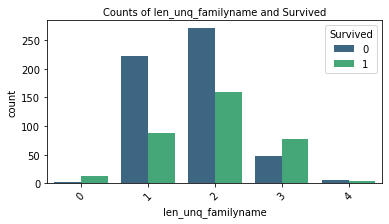

len_char_familyname
0 missing values filled with '-'
len_char_familyname - chi2: 34.6637; p value: 0.147592003 



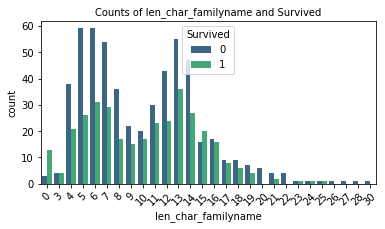

ticket_type
0 missing values filled with '-'
ticket_type - chi2: 55.6584; p value: 0.0006245083 



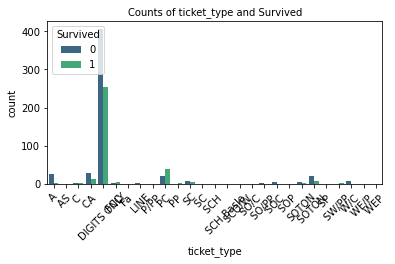

cabin_type
0 missing values filled with '-'
cabin_type - chi2: 99.1642; p value: 0.0 



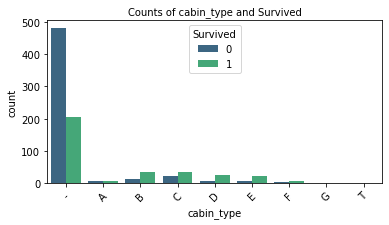

cabin_frequency
0 missing values filled with '-'
cabin_frequency - chi2: 91.9581; p value: 0.0 



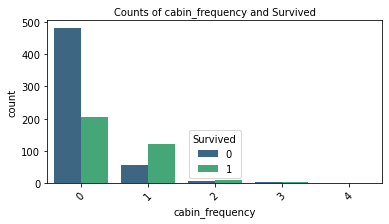

cabin_assigned
0 missing values filled with '-'
cabin_assigned - chi2: 87.9415; p value: 0.0 



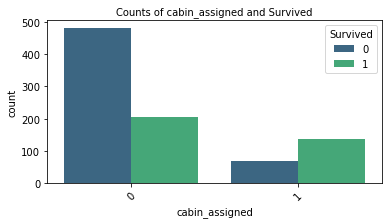

passengerid_bins
0 missing values filled with '-'
passengerid_bins - chi2: 5.9387; p value: 0.2037744439 



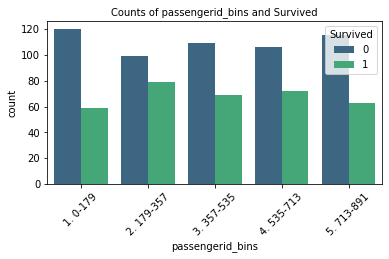

age_bins
0 missing values filled with '-'
age_bins - chi2: 20.2335; p value: 0.0004490879 



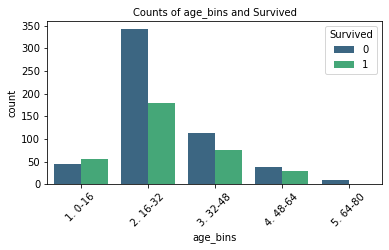

Calculating for numeric variables... 

q1: 22.0, q3: 35.0
2.5
0 missing values filled with 0
Age - t statistic: -0.8162; p value: 0.4146449669 



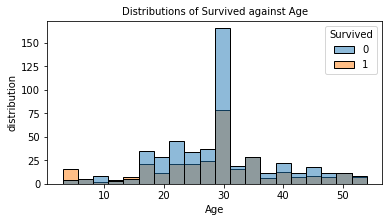

In [38]:
# implement
stats_test(train_df,
           target_variable='Survived',
           categorical_variable=['Pclass','Sex','SibSp','Parch','Embarked','prefix_name',
                                 'len_unq_firstname','len_char_firstname','len_unq_familyname','len_char_familyname','ticket_type',
                                 'cabin_type','cabin_frequency','cabin_assigned','passengerid_bins','age_bins'],
           numeric_variable=['Age'])

- Looking at the p-values, independent variables that don't seem to have a statistically signifiant relationship with the target variable are: `len_unq_firstname`, `len_char_firstname`, `len_char_familyname`, `passengerid_bins` and `age` when `age` is used as a continuous variable (as opposed to manual binning)
- A caveat to the statistical tests is that my intention of using it is not for an end goal to draw population inferences from, rather I use it as an intermediary step to quickly discern potential correlations between variables. 
- This means I am not as rigorous as I ought to be in ensuring that the nature of each independent variable satisfies the assumptions of the respective statistical tests. 
- For eg: Some of my categorical variables have small sample sizes in some categories. My only numeric variable, `age`, is not normally distributed either. On the last part - this may explain the different p-values when `age` is used numerically and categorically. 
- In any case, when taken with a pinch of salt, we take note that the following variables may have some importance:

`Pclass`, `Sex`, `SibSp`, `Parch`, `Embarked`, `Prefix_name`, `len_unq_familyname`, `ticket_type`, `cabin_type`, `cabin_frequency`, `cabin_assigned`

---

<a id='base-models'></a>
## <u> Fit base models </u>


- Let's fit a few classification models with their default hyperparameters: Logistic Regression, Decision Tree, Random Forest, LightGBM Classifier

In [39]:
# remove `Cabin`, `Ticket`, `Name`, `PassengerId` from feature space
rem = ['Cabin','Ticket','Name','PassengerId']

train_df.drop(rem, axis=1, inplace=True)

x_cols = train_df.columns.tolist()
x_cols.remove('Survived')

In [40]:
x_cols

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'prefix_name',
 'len_unq_firstname',
 'len_char_firstname',
 'len_unq_familyname',
 'len_char_familyname',
 'ticket_type',
 'cabin_type',
 'cabin_frequency',
 'cabin_assigned',
 'passengerid_bins',
 'age_bins']

<u> 1) `Logistic Regression` </u>

Assumptions:

a) Encode categorical variables

b) Low number of outliers 

c) Low multicollinearity between predictors

d) Linear trend of log odds and numeric predictors

e) I.i.d. random variables

In [41]:
# split dataset
X, y = train_df[x_cols], train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train) + len(X_test) == len(X)

a) Categorical encoding

- Only for training set used fr Logistic Regression

In [42]:
# encode categorical variables 
cat_vars = []

for i in X_train.columns:
    if X_train[i].dtype == 'object':
        cat_vars.append(i)

cat_vars.append('Pclass')

# one hot encode: `Sex`, `Embarked`, `prefix_name`, `ticket_type`, `cabin_type`
X_train = pd.get_dummies(X_train, columns=['Pclass','Sex','Embarked','prefix_name','ticket_type','cabin_type'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Pclass','Sex','Embarked','prefix_name','ticket_type','cabin_type'], drop_first=True)

# convert booleans to integers
for i in X_train.columns:
    if X_train[i].dtype == 'bool':
        X_train[i] = X_train[i].astype(int)

for i in X_test.columns:
    if X_test[i].dtype == 'bool':
        X_test[i] = X_test[i].astype(int)
        
# label encode: `passengerid_bins`, `age_bins`
label_encoder = LabelEncoder()
X_train['passengerid_bins_encoded'] = label_encoder.fit_transform(X_train['passengerid_bins'])
X_train['age_bins_encoded'] = label_encoder.fit_transform(X_train['age_bins'])
X_test['passengerid_bins_encoded'] = label_encoder.fit_transform(X_test['passengerid_bins'])
X_test['age_bins_encoded'] = label_encoder.fit_transform(X_test['age_bins'])

# remove cols
X_train.drop(columns=['passengerid_bins','age_bins'], inplace=True, axis=1)
X_test.drop(columns=['passengerid_bins','age_bins'], inplace=True, axis=1)

In [43]:
# remove column whitespaces 
X_train.columns = [i.strip() for i in X_train.columns]
X_test.columns = [i.strip() for i in X_test.columns]

In [44]:
# drop dups 
X_train = X_train.loc[:, ~X_train.columns.duplicated(keep='first')]
X_test = X_test.loc[:, ~X_test.columns.duplicated(keep='first')]

In [45]:
# ensure all encoded variables are found in both training and test sets 
if len(X_train.columns) > len(X_test.columns):
    diff = [i for i in X_train.columns if i not in X_test.columns]
    X_train.drop(columns=diff, inplace=True)
    # X_test[diff] = 0
elif len(X_train.columns) < len(X_test.columns):
    diff = [i for i in X_test.columns if i not in X_train.columns]
    X_test.drop(columns=diff, inplace=True)
    # X_train[diff] = 0
else:
    pass

In [48]:
assert len(X_train.columns) == len(X_test.columns)

In [47]:
# order columns 
X_test = X_test[X_train.columns]

b) Outliers

In [49]:
# check outliers
num_vars = []

for i in X_train.columns:
    if '_'.join(i.split('_')[:-1]) == '':
        num_vars.append(i)
    elif (any('_'.join(i.split('_')[:-1]) in j for j in cat_vars)) or ('encoded' in i.split('_')[-1]):
        pass
    else:
        num_vars.append(i)

for i in num_vars:
    print(i)
    q1 = np.percentile(X_train[i], 25)
    q3 = np.percentile(X_train[i], 75)
    iqr = q3-q1
    outliers = X_train[~(X_train[i] >= (q1-iqr*1.5)) & (X_train[i] <= (q3+iqr*1.5))]
    print(f"{i} has {len(outliers)} outliers \n")

Age
Age has 6 outliers 

SibSp
SibSp has 0 outliers 

Parch
Parch has 0 outliers 

Fare
Fare has 0 outliers 

len_unq_firstname
len_unq_firstname has 0 outliers 

len_char_firstname
len_char_firstname has 0 outliers 

len_unq_familyname
len_unq_familyname has 0 outliers 

len_char_familyname
len_char_familyname has 0 outliers 



- Not many outliers based on the IQR method. Will leave them be.

c) Multicollinearity

In [50]:
# check multicollinearity using VIF
X_train_with_const = add_constant(X_train)

for i in X_train_with_const.columns:
    if X_train_with_const[i].dtype == bool:
        X_train_with_const[i] = X_train_with_const[i].astype(int)

vif_df = pd.DataFrame()
vif_df['predictors'] = X_train_with_const.columns 
vif_df['VIF'] = [variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])]

vif_df.sort_values(by=['VIF'], ascending=False)

,predictors,VIF
0,const,363.478612
10,cabin_assigned,136.770554
13,Sex_male,72.515031
35,cabin_type_C,48.993525
17,prefix_name_Miss,43.035136
...,...,...
31,ticket_type_SOTON,1.078257
40,passengerid_bins_encoded,1.059647
25,ticket_type_LINE,1.050527
28,ticket_type_SCH,1.044205


- We see some predictors with extremely high multicollinearity, which implies that the interpretability of coefficients may not be reliable
- Let's remove the one hot encoded variables that may contribute to high multicollinearity due to encoding and binning

In [51]:
# only include numeric predictors
X_train_vif = X_train[num_vars]

# recheck
X_train_with_const = add_constant(X_train_vif)

for i in X_train_with_const.columns:
    if X_train_with_const[i].dtype == bool:
        X_train_with_const[i] = X_train_with_const[i].astype(int)

vif_df = pd.DataFrame()
vif_df['predictors'] = X_train_with_const.columns 
vif_df['VIF'] = [variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])]

vif_df.sort_values(by=['VIF'], ascending=False)

,predictors,VIF
0,const,38.183320
7,len_unq_familyname,2.883301
8,len_char_familyname,2.850947
6,len_char_firstname,1.349858
5,len_unq_firstname,1.341504
3,Parch,1.292637
2,SibSp,1.276090
4,Fare,1.133521
1,Age,1.093030


- Without the one hot encoded variables, the VIF of numeric predictors are less than 5

d) Linearity 

In [52]:
# linearity between log odds and numeric predictors using Box-Tidwell 
for i in num_vars:
    print(i)
    bt_df = X_train.copy()
    
    new_vars = [f"{i}",f"{i}_log",'intercept']
    bt_df = bt_df[[new_vars[0]]] # existing predictor 
    bt_df['intercept'] = 1 # add intercept 
    bt_df[f"{i}_log"] = bt_df[f"{i}"] * np.log(bt_df[f"{i}"])
    bt_df['Survived'] = y_train # add target variable
    
    # exclude rows where number is 0 (log of 0 or negative numbers throws an error)
    bt_df = bt_df[bt_df[new_vars[0]]>0]
    
    # fit logistic regression
    logit = sm.Logit(bt_df['Survived'], bt_df[new_vars])
    results = logit.fit()
    
    # print results 
    print(f"Results for predictor {i}")
    print(results.summary())
    print('\n')

Age
Optimization terminated successfully.
         Current function value: 0.651772
         Iterations 4
Results for predictor Age
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            2
Date:                Sat, 18 Jan 2025   Pseudo R-squ.:                 0.01691
Time:                        22:34:30   Log-Likelihood:                -464.06
converged:                       True   LL-Null:                       -472.04
Covariance Type:            nonrobust   LLR p-value:                 0.0003419
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.2278      0.062     -3.689      0.000      -0.349      -0.107

- Seems like `Age` and `Fare` have significant p-values for the original predictors and their transformed predictors, which may indicate a non-linear relationship.

In [53]:
# remove column whitespaces 
X_train.columns = [i.strip() for i in X_train.columns]
X_test.columns = [i.strip() for i in X_test.columns]

In [54]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

lr_y_pred = lr_model.predict(X_test)
lr_y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

In [55]:
# evaluation - accuracy, precision, recall, confusion matrix, ROC AUC
def classification_evaluation(
    y_test: str,
    y_pred: str
):
    """
    Calculate evaluation metrics for classification task
    
    """
    
    accuracy = round(accuracy_score(y_test, y_pred),2)
    precision = round(precision_score(y_test, y_pred),2)
    recall = round(recall_score(y_test, y_pred),2)
    f1 = round(f1_score(y_test, y_pred),2)
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm,
                         index=['Actual 0','Actual 1'],
                         columns=['Predicted 0','Actual 0'])
    aucroc = round(roc_auc_score(y_test, y_pred),2)
    
    results = pd.DataFrame(columns=['accuracy','precision','recall','f1','aucroc'])
    results.loc[0] = accuracy,precision,recall,f1,aucroc
    
    print(f"Confusion matrix: \n")
    print(cm_df)
    print('\n')
    print(results.loc[0])
    

In [56]:
classification_evaluation(y_test, lr_y_pred)

Confusion matrix: 

          Predicted 0  Actual 0
Actual 0           92        14
Actual 1           21        52


accuracy     0.80
precision    0.79
recall       0.71
f1           0.75
aucroc       0.79
Name: 0, dtype: float64


In [57]:
# copy training and test set used for logistic Regression for later hyperparameter tuning
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()
X_test_lr = X_test.copy()
y_test_lr = y_test.copy()

<u> 2) `Decision Tree` </u>

- A lot more flexible than linear models as it doesn't assume a certain distribution of the data.
- Higher ability to model data with complex, non-linear relationships.

In [58]:
# fit decision tree
de_model = DecisionTreeClassifier()
de_model = de_model.fit(X_train,y_train)
de_y_pred = de_model.predict(X_test)

In [59]:
classification_evaluation(y_test, de_y_pred)

Confusion matrix: 

          Predicted 0  Actual 0
Actual 0           87        19
Actual 1           32        41


accuracy     0.72
precision    0.68
recall       0.56
f1           0.62
aucroc       0.69
Name: 0, dtype: float64


3) `Random Forest`

- To deal with overfitting

In [60]:
# fit random forest
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train,y_train)
rf_y_pred = rf_model.predict(X_test)

In [61]:
classification_evaluation(y_test, rf_y_pred)

Confusion matrix: 

          Predicted 0  Actual 0
Actual 0           97         9
Actual 1           32        41


accuracy     0.77
precision    0.82
recall       0.56
f1           0.67
aucroc       0.74
Name: 0, dtype: float64


4) `LightGBM Classifier`

In [62]:
# resplit training and test sets
X, y = train_df[x_cols], train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train) + len(X_test) == len(X)

# do not encode categorical variables 
cat_vars = []

for i in X_train.columns:
    if X_train[i].dtype == 'object':
        cat_vars.append(i)

cat_vars.append('Pclass')

for i in cat_vars:
    X_train[i] = X_train[i].astype('category')
    X_test[i] = X_test[i].astype('category')

In [63]:
# fit lightgbm
train_data = lgb.Dataset(data=X_train,
                         label=y_train,
                         categorical_feature='auto'
                         )

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}


lgb_model = lgb.train(params=params, train_set=train_data)

[LightGBM] [Info] Number of positive: 269, number of negative: 443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377809 -> initscore=-0.498858
[LightGBM] [Info] Start training from score -0.498858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [64]:
# predict 
lgb_y_pred = lgb_model.predict(X_test)

lgb_y_pred_binary = [1 if i>0.5 else 0 for i in lgb_y_pred]

classification_evaluation(y_test, lgb_y_pred_binary)

Confusion matrix: 

          Predicted 0  Actual 0
Actual 0           95        11
Actual 1           28        45


accuracy     0.78
precision    0.80
recall       0.62
f1           0.70
aucroc       0.76
Name: 0, dtype: float64


- Seems like the Logistic Regression and LightGBM Classifier models had the highest accuracies
- Now I will try to finetune these 2 models.

---

<a id='finetune'></a>
## <u> Finetune Logistic Regression and LightGBM Classifier </u>

1) `Logistic Regression`

In [65]:
lr_model_v2 = LogisticRegression(solver='liblinear')

pipeline = Pipeline(steps=[('scaler',StandardScaler()), ('lr_model',lr_model_v2)])

# params
params = {
    'C': [0.01,0.1,1,10,100,120],
    'penalty': ['l1','l2']
}

# grid search with cv. to optimise for accuracy
grid_search = GridSearchCV(
    lr_model_v2, 
    param_grid=params, 
    cv=5, 
    scoring='accuracy'
)

# fit 
grid_search.fit(X_train_lr,y_train_lr)

# best params 
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"best params: {best_params}; best accuracy score: {best_score}")

best params: {'C': 1, 'penalty': 'l2'}; best accuracy score: 0.8328868314783808


In [66]:
# predict
lr_y_pred_v2 = grid_search.predict(X_test_lr)

classification_evaluation(y_test_lr, lr_y_pred)

Confusion matrix: 

          Predicted 0  Actual 0
Actual 0           92        14
Actual 1           21        52


accuracy     0.80
precision    0.79
recall       0.71
f1           0.75
aucroc       0.79
Name: 0, dtype: float64


- Same scores as the base Logistic Regression model

In [67]:
# fit with best hyperparameters 
params = {
    'solver': 'liblinear',
    'C': 100,
    'penalty': 'l2'
}

lr_model_v3 = LogisticRegression(**params)

lr_model_v3.fit(X_train_lr,y_train_lr)

lr_y_pred_v3 = lr_model_v3.predict(X_test_lr)

classification_evaluation(y_test_lr, lr_y_pred_v3)

Confusion matrix: 

          Predicted 0  Actual 0
Actual 0           88        18
Actual 1           24        49


accuracy     0.77
precision    0.73
recall       0.67
f1           0.70
aucroc       0.75
Name: 0, dtype: float64


2) `LightGBM Classifier`

Random search

In [68]:
lgb_model_v2 = lgb.LGBMClassifier()

# params
params_random = {
    'num_leaves': np.arange(10,30,5),
    'max_depth': np.arange(2,8),
    'max_bin': np.arange(100,300,50),
    'min_data_in_leaf': [20,35,50],
    'learning_rate': [0.01,0.05,0.1,0.15,0.2],
    'n_estimators': [50,100,150,200],
    'subsample': [0.4,0.8,1.0]
}

# random search with cv 
random_search = RandomizedSearchCV(
    estimator=lgb_model_v2,
    param_distributions=params_random,
    n_iter=50,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Info] Number of positive: 269, number of negative: 443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377809 -> initscore=-0.498858
[LightGBM] [Info] Start training from score -0.498858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_bin': array([100, 150, 200, 250]),
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'min_data_in_leaf': [20, 35, 50],
                                        'n_estimators': [50, 100, 150, 200],
                                        'num_leaves': array([10, 15, 20, 25]),
                                        'subsample': [0.4, 0.8, 1.0]},
                   random_state=42, verbose=1)

In [69]:
# best params 
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"best params: {best_params}; best accuracy score: {best_score}")

best params: {'subsample': 0.4, 'num_leaves': 10, 'n_estimators': 100, 'min_data_in_leaf': 35, 'max_depth': 4, 'max_bin': 250, 'learning_rate': 0.05}; best accuracy score: 0.8469220919925144


In [70]:
# predict
best_model_v2 = random_search.best_estimator_ 
test_score = best_model_v2.score(X_test, y_test)
test_score

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


0.776536312849162

Grid search

In [71]:
lgb_model_v3 = lgb.LGBMClassifier()

# grid search 
subsample = random_search.best_params_['subsample']
num_leaves = random_search.best_params_['num_leaves']
n_estimators = random_search.best_params_['n_estimators']
min_data_in_leaf = random_search.best_params_['min_data_in_leaf']
max_depth = random_search.best_params_['max_depth']
max_bin = random_search.best_params_['max_bin']
learning_rate = random_search.best_params_['learning_rate']                                      

params_grid = {
    'subsample': [subsample-0.1,subsample,subsample+0.1],
    'num_leaves': [num_leaves-5,num_leaves,num_leaves+5],
    'n_estimators': [n_estimators-10,n_estimators,n_estimators+10],
    'min_data_in_leaf': [min_data_in_leaf,min_data_in_leaf+10,min_data_in_leaf+20],
    'max_depth': [max_depth-1,max_depth,max_depth+1],
    'max_bin': [max_bin-100,max_bin-50,max_bin],
    'learning_rate': [learning_rate]
}

grid_search_v3 = GridSearchCV(
    estimator=lgb_model_v3,
    param_grid=params_grid,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# fit 
grid_search_v3.fit(X_train,y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Info] Number of positive: 269, number of negative: 443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377809 -> initscore=-0.498858
[LightGBM] [Info] Start training from score -0.498858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_bin': [150, 200, 250],
                         'max_depth': [3, 4, 5],
                         'min_data_in_leaf': [35, 45, 55],
                         'n_estimators': [90, 100, 110],
                         'num_leaves': [5, 10, 15],
                         'subsample': [0.30000000000000004, 0.4, 0.5]},
             verbose=1)

In [72]:
best_params = grid_search_v3.best_params_
best_score = grid_search_v3.best_score_

print(f"best params: {best_params}; best accuracy score: {best_score}")

best params: {'learning_rate': 0.05, 'max_bin': 250, 'max_depth': 4, 'min_data_in_leaf': 35, 'n_estimators': 100, 'num_leaves': 10, 'subsample': 0.30000000000000004}; best accuracy score: 0.8469220919925144


In [73]:
# predict
best_model_v3 = grid_search_v3.best_estimator_ 
test_score = best_model_v3.score(X_test, y_test)
test_score

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35


0.776536312849162

- Seems like the best model would be a lightGBM classifier with the following hyperparameters:
{'learning_rate': 0.05, 'max_bin': 250, 'max_depth': 5, 'min_data_in_leaf': 35, 'n_estimators': 100, 'num_leaves': 10, 'subsample': 0.30000000000000004}

In [74]:
# feature importance
feature_imp = best_model_v3.feature_importances_

features = X_train.columns.tolist()

feature_imp_dict = {}

for i,j in enumerate(feature_imp):
    feature_imp_dict[features[i]] = j

dict(sorted(feature_imp_dict.items(), key=lambda item: item[1], reverse=True))

{'Fare': 168,
 'Age': 158,
 'len_char_familyname': 104,
 'Pclass': 53,
 'len_char_firstname': 51,
 'Sex': 50,
 'SibSp': 39,
 'Embarked': 33,
 'prefix_name': 29,
 'cabin_frequency': 29,
 'passengerid_bins': 26,
 'len_unq_familyname': 24,
 'cabin_type': 16,
 'Parch': 7,
 'cabin_assigned': 1,
 'len_unq_firstname': 0,
 'ticket_type': 0,
 'age_bins': 0}

- Features that seem redundant are: `len_unq_firstname`, `ticket_type`, `cabin_assigned`, `age_bins`

In [75]:
# remove features that are not important and retrain
X_train.drop(columns=['len_unq_firstname','ticket_type','cabin_assigned','age_bins'], axis=1, inplace=True)
X_test.drop(columns=['len_unq_firstname','ticket_type','cabin_assigned','age_bins'], axis=1, inplace=True)

In [76]:
# fit with best hyperparameters
train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature='auto')

params = {
    'subsample': 0.3,
    'num_leaves': 10,
    'n_estimators': 100,
    'min_data_in_leaf': 35,
    'max_depth': 5,
    'max_bin': 250,
    'learning_rate': 0.05
}

lgb_model_v4 = lgb.train(params=params, train_set=train_data)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 14
[LightGBM] [Info] Start training from score 0.377809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [77]:
# predict 
lgb_y_pred = lgb_model_v4.predict(X_test)

lgb_y_pred_binary = [1 if i>0.5 else 0 for i in lgb_y_pred]

classification_evaluation(y_test, lgb_y_pred_binary)

Confusion matrix: 

          Predicted 0  Actual 0
Actual 0           98         8
Actual 1           30        43


accuracy     0.79
precision    0.84
recall       0.59
f1           0.69
aucroc       0.76
Name: 0, dtype: float64


- After hyperparameter tuning, the accuracies of Logistic Regression and LightGBM Classifiers are similar 0.78, with some differences in the other metrics. For example, AUC-ROC is higher with the former.
- The final model I will be using is the Logistic Regression.

---

<a id='predict'></a>
## <u> Prep and predict test set </u>

In [78]:
test_df = pd.read_csv('./dataset/test.csv')
passenger_id = test_df['PassengerId']

In [79]:
# apply all feature engineering steps done on training set to test set

# create 5 new columns from `Name`
test_df['prefix_name'] = test_df['Name'].apply(lambda x: extract_prefix(name=x))
test_df[['len_unq_firstname','len_char_firstname']] = test_df['Name'].apply(lambda x: pd.Series(extract_firstname(name=x)))
test_df[['len_unq_familyname','len_char_familyname']] = test_df['Name'].apply(lambda x: pd.Series(extract_familyname(name=x)))

# create 1 new column from `Ticket`
test_df['ticket_type'] = ''

for i,j in test_df.iterrows():
    resp = re.match(r'^\D*', j['Ticket']).group()
    if len(resp) > 0:
        test_df.loc[i,'ticket_type'] = resp
    else: # numbers only
        test_df.loc[i,'ticket_type'] = 'DIGITS ONLY'

# standardise ticket names 
for k,v in regroup_ticket_types.items(): # regroup_ticket_types defined statically for training set
    # replace 
    for i in v:
        test_df['ticket_type'] = test_df['ticket_type'].str.replace(i, k)

# remaining `Ticket` as 'others'
for i,j in test_df.iterrows():
    for a in as_others: # as_others defined statically for training set 
        if j['ticket_type'] == a:
            test_df.loc[i,'ticket_type'] = 'OTHERS'
        else:
            pass

# create new columns from `Cabin`
test_df['Cabin'] = test_df['Cabin'].fillna('-')
test_df['cabin_type'] = [i[0] for i in test_df['Cabin']]
test_df['cabin_frequency'] = [len(i.split( )) if i != '-' else 0 for i in test_df['Cabin']]
test_df['cabin_assigned'] = [1 if i != '-' else 0 for i in test_df['Cabin']]

# create new columns from `PassengerId`
labels = ['1. 0-179', '2. 179-357', '3. 357-535', '4. 535-713', '5. 713-891']
test_df['passengerid_bins'] = pd.cut(test_df['PassengerId'], bins=5, labels=labels)
test_df['passengerid_bins'] = test_df['passengerid_bins'].astype('object')

# create new columns from `Age`
labels = ['1. 0-16', '2. 16-32', '3. 32-48', '4. 48-64', '5. 64-80']
test_df['age_bins'] = pd.cut(test_df['Age'], bins=5, labels=labels)
test_df['age_bins'] = test_df['age_bins'].astype('object')

In [80]:
# encode categorical variables 
cat_vars = []

for i in test_df.columns:
    if test_df[i].dtype == 'object':
        cat_vars.append(i)

cat_vars.append('Pclass')

# one hot encode: `Sex`, `Embarked`, `prefix_name`, `ticket_type`, `cabin_type`
test_df = pd.get_dummies(test_df, columns=['Pclass','Sex','Embarked','prefix_name','ticket_type','cabin_type'], drop_first=True)

# convert booleans to integers
for i in test_df.columns:
    if test_df[i].dtype == 'bool':
        test_df[i] = test_df[i].astype(int)
        
# label encode: `passengerid_bins`, `age_bins`
label_encoder = LabelEncoder()
test_df['passengerid_bins_encoded'] = label_encoder.fit_transform(test_df['passengerid_bins'])

# missing values
mean_age = round(test_df['Age'].mean(),0)
mean_fare = round(test_df['Fare'].mean(),0)

# impute 
test_df['Age'] = test_df['Age'].fillna(mean_age)
test_df['Fare'] = test_df['Fare'].fillna(mean_fare)

test_df['age_bins_encoded'] = label_encoder.fit_transform(test_df['age_bins'])

# remove cols
test_df.drop(columns=['passengerid_bins','age_bins'], inplace=True, axis=1)

# remove whitespaces from columns 
test_df.columns = [i.strip() for i in test_df.columns]

In [81]:
# remove dup cols 
test_df = test_df.loc[:, ~test_df.columns.duplicated(keep='first')]

In [82]:
# make sure columns match training set
training_cols = X_train_lr.columns.tolist()

remove = []
add = []

for i in test_df.columns:
    if i not in training_cols:
        remove.append(i)

for i in training_cols:
    if i not in test_df.columns:
        add.append(i)

# remove or add new columns 
test_df.drop(columns=remove, axis=1, inplace=True)

for i in add:
    test_df[i] = 0

assert len(test_df.columns) == len(X_train_lr.columns)

In [83]:
# format
test_df = test_df[X_train_lr.columns]

In [84]:
# results
results = pd.DataFrame()
results['PassengerId'] = passenger_id
results['Survived'] = lr_model_v3.predict(test_df)

In [134]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [86]:
# save model 
import pickle 

with open("./saved_model/titanic_predictor.pkl", "wb") as file: 
    pickle.dump(lr_model_v3, file)

In [87]:
# from IPython.display import HTML

# def create_download_link(title = "Download CSV file", filename = "data.csv"):  
#     html = '<a href={filename}>{title}</a>'
#     html = html.format(title=title,filename=filename)
#     return HTML(html)

# # create a link to download the dataframe which was saved with .to_csv method
# create_download_link(filename='titanic_submission.csv')

---

<a id='conclusion'></a>
## <u> Conclusion </u>

Could have done more with feature engineering.